# Open problems: single cell perturbation
## Preprocessing perturbation data
### by Jalil Nourisa

# Imports

In [192]:
import os, binascii
import scipy
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import random
import anndata as ad
from matplotlib.patches import Patch
import warnings
from scipy import sparse

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

In [193]:
colors_cell_type = ['#c4d9b3', '#c5bc8e', '#c49e81', '#c17d88', 'gray', 'lightsteelblue']

In [194]:
warnings.filterwarnings("ignore")
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})
sc.settings.verbosity = 0


work_dir = f'../output'
out_edger_dir= f'{work_dir}/de_analysis/edger'
out_limma_dir= f'{work_dir}/de_analysis/limma'


bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
negative_control = 'Dimethyl Sulfoxide'
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']
T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}



# load and save haousekeeping genes
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')


## Common functions 
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

def isolation_forest(df_subset, group=['index'], cell_type_col='cell_type', values_col='cell_count'):
    """
        Identifies outlier compounds based on ratio of cell type in pseudobulked samples. 
    """
    from sklearn.ensemble import IsolationForest
    cell_count_m = df_subset.pivot(index=group, columns=cell_type_col, values=values_col)
    cell_count_ratio = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
    cell_count_ratio = cell_count_ratio.fillna(0)
    clf = IsolationForest(max_samples=100, random_state=0)
    clf.fit(cell_count_ratio.values)
    outlier_compounds = cell_count_ratio.index[clf.predict(cell_count_ratio.values)==-1]
    return outlier_compounds

def plot_scatter_single(obs, ax, xs, ys, x_label='', y_label='', log_x=True, log_y=False):
    """
        Scatter plot to showcase the distribution of a given variable across different groups. 
    """
    
    alpha = .6
    size = 4
    included_vars = np.unique(obs)
    for i, sub_var in enumerate(included_vars):
        label = sub_var
        mask = (obs == sub_var)
        ax.scatter(xs[mask], ys[mask], label=sub_var, alpha=alpha, color=colors_cell_type[i], s=size)

    ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')
    ax.margins(0.05)
    ax.spines[['right', 'top']].set_visible(False)
    # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
    prop = {'size': 9}
    
    handles = []
    for kk, label in enumerate(included_vars):
        handles.append(Patch(facecolor=colors_cell_type[kk], label=label))
    
    ax.legend(handles=handles, prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)

def plot_scatter(obs, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    """
        Scatter plot to showcase the distribution of given variables across different groups. 
    """
    n_axes = len(obs_index)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    alpha = .6
    size = 4
    for i_index, index in enumerate(obs_index):
        # i = i_index // n_axes
        j = i_index % n_axes
        ax = axes[j]

        index_vars = obs[index]
        
        if index=='sm_name':
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=alpha, color='blue')
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=alpha, color='cyan', s=size)
            
        else:
            included_vars = index_vars.unique()
            for i, var in enumerate(included_vars):
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=alpha, color=colors_cell_type[i], s=size)

        ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        
        handles = []
        for kk, label in enumerate(included_vars if (index != 'sm_name') else ['Rest', 'Positive control']):
            if index == 'sm_name':
                handles.append(Patch(facecolor=['blue', 'cyan'][kk], label=label))
            else:
                handles.append(Patch(facecolor=colors_cell_type[kk], label=label))
        
        ax.legend(handles=handles, prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
    return fig, axes

# EDA on single cell data

In [195]:
sc_counts = ad.read_h5ad(f'{work_dir}/../input/sc_counts_cleaned.h5ad')
sc_counts.var_names_make_unique()
sc_counts.obs['positive_ctr'] = sc_counts.obs.sm_name.isin(controls2)

KeyboardInterrupt: 

In [ ]:
import sctk
# sctk.calculate_qc(sc_counts, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
sctk.calculate_qc(sc_counts)
sctk.cellwise_qc(sc_counts)

n_counts: [2451.0716313167804, 29992.009765625], 298152/301785 passed
n_genes: [1024.870089721006, 6238.99853515625], 297247/301785 passed
percent_mito: [0.025329280644655228, 18.950448181593497], 300892/301785 passed
percent_ribo: [7.117446014036448, 51.64668405810869], 296240/301785 passed
percent_hb: [0.0, 0.00920543506616024], 191652/301785 passed
183592/301785 pass


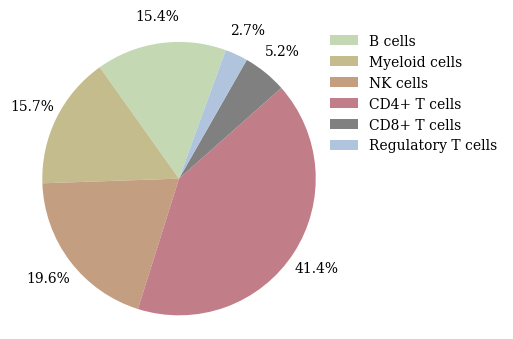

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(5, 3.5))  # Adjust the figure size as needed

ax.pie(
    [15.4, 15.7, 19.6, 41.4, 5.2, 2.7], autopct='%1.1f%%',
    startangle=70, colors=['#c4d9b3', '#c5bc8e', '#c49e81', '#c17d88', 'gray', 'lightsteelblue'], pctdistance=1.2,
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()


handles = []
for kk, label in enumerate(['B cells', 'Myeloid cells', 'NK cells', 'CD4+ T cells', 'CD8+ T cells', 'Regulatory T cells']):
    if index == 'sm_name':
        handles.append(Patch(facecolor=['blue', 'cyan'][kk], label=label))
    else:
        handles.append(Patch(facecolor=colors_cell_type[kk], label=label))

ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios_original.png', dpi=100, transparent=True)
plt.show()

In [ ]:
# merge T cells
sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].map(cell_type_map)
sc_counts.obs['cell_type'].unique()

array(['B cells', 'T cells', 'Myeloid cells', 'NK cells'], dtype=object)

In [ ]:
# simplify plate name
sc_counts.obs['plate_name'] = sc_counts.obs['plate_name'].astype(str).apply(lambda name: name.split('-')[1]).astype('category')
# group cell types per well
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')

## QC 

In [ ]:
sctk.default_metric_params_df

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.10
n_genes,100.00,NaN,log,min_only,0.10
percent_mito,0.01,20.0,log,max_only,0.10
percent_ribo,0.00,100.0,log,both,0.10
percent_hb,NaN,1.0,log,max_only,0.10
percent_soup,NaN,5.0,log,max_only,0.10
percent_spliced,50.00,97.5,log,both,0.10
scrublet_score,NaN,0.3,linear,max_only,0.95


### Cell wise

In [ ]:
def min_max(name, data):
    print(f'{name}: min:{data.min()}, max: {data.max()}')
min_max('n_counts', sc_counts.obs.n_counts)
min_max('n_genes', sc_counts.obs.n_genes)
min_max('percent_hb', sc_counts.obs.percent_hb)
min_max('percent_mito', sc_counts.obs.percent_mito)

n_counts: min:1947.0, max: 29992.0
n_genes: min:101, max: 6239
percent_hb: min:0.0, max: 95.78558943484171
percent_mito: min:0.025329280648429587, max: 20.068317677198973


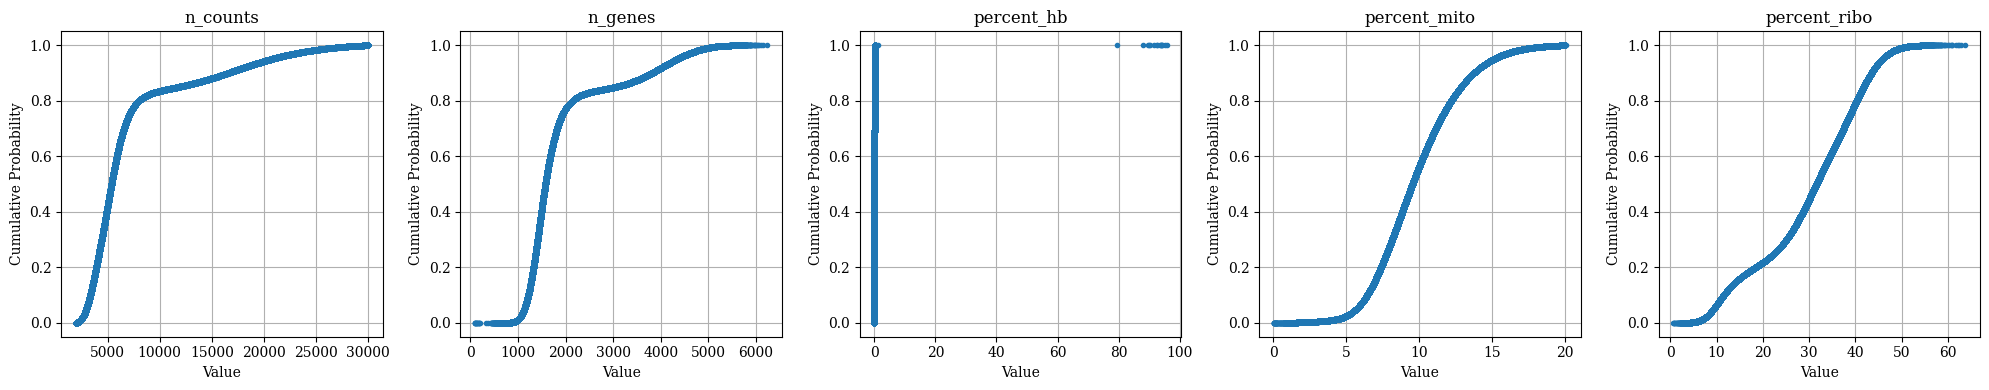

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(sc_counts.obs.n_counts, 'n_counts', axes[0])
plot_CDF(sc_counts.obs.n_genes, 'n_genes', axes[1])
plot_CDF(sc_counts.obs.percent_hb, 'percent_hb', axes[2])
plot_CDF(sc_counts.obs.percent_mito, 'percent_mito', axes[3])
plot_CDF(sc_counts.obs.percent_ribo, 'percent_ribo', axes[4])
plt.tight_layout()
plt.show()

In [ ]:
# for cells
print('n_counts:', sc_counts.obs.n_counts.min(), sc_counts.obs.n_counts.max())
print('n_genes:', sc_counts.obs.n_genes.min(), sc_counts.obs.n_genes.max())
print('percent_mito:', sc_counts.obs.percent_mito.min(), sc_counts.obs.percent_mito.max())
print('percent_ribo:', sc_counts.obs.percent_ribo.min(), sc_counts.obs.percent_ribo.max())
print('percent_hb:', sc_counts.obs.percent_hb.min(), sc_counts.obs.percent_hb.max())

n_counts: 1947.0 29992.0
n_genes: 101 6239
percent_mito: 0.025329280648429587 20.068317677198973
percent_ribo: 0.5988023952095809 63.80191274728154
percent_hb: 0.0 95.78558943484171


In [ ]:
filter_percent_hb = sc_counts.obs.percent_hb>.2
filter_percent_hb.sum()

20

### Gene wise

In [ ]:
plates = sc_counts.obs['plate_name'].unique()

# Step 2: Initialize a DataFrame to store counts
gene_counts_per_plate = pd.DataFrame(index=sc_counts.var_names, columns=plates, dtype=int)

# Step 3: Iterate over each plate and calculate expression counts
for plate in plates:
    # Subset the AnnData object for the current plate
    subset = sc_counts[sc_counts.obs['plate_name'] == plate]
    
    # Calculate expression counts (genes x cells > 0)
    expressed_genes = (subset.X > 0).sum(axis=0)
    
    # Check if the result needs conversion from sparse matrix format
    if isinstance(expressed_genes, np.matrix):
        expressed_genes = np.array(expressed_genes).flatten()
    
    # Store the counts in the DataFrame
    gene_counts_per_plate[plate] = expressed_genes

# Step 4: Aggregate counts across plates (max or sum based on the requirement)
# We use `max` here to find if any gene meets the criteria in at least one plate
max_counts = gene_counts_per_plate.max(axis=1)

# Step 5: Create a mask for genes to keep (genes expressed in at least 100 cells in any plate)
genes_to_keep = max_counts >= 100    

### Actual filtering

In [ ]:
sc_counts = sc_counts[(~filter_percent_hb), genes_to_keep]

In [ ]:
sc_counts.obs = sc_counts.obs[['cell_type', 'sm_name', 'donor_id', 'row', 'plate_name', 'well']]
sc_counts.var = sc_counts.var[[]]

del sc_counts.obsm
del sc_counts.uns

In [ ]:
sc_counts.write(f'{work_dir}/../input/sc_counts_f.h5ad')

# Pseudobulking counts 

In [ ]:
sc_counts= ad.read_h5ad(f'{work_dir}/../input/sc_counts_f.h5ad')

In [ ]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [ ]:
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(sc_counts, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values
bulk_adata.X = np.array(bulk_adata.X.todense())

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

bulk_adata.var.set_index('index', inplace=True)

bulk_adata.write(f'{work_dir}/preprocess/bulk_adata.h5ad')

ratio of missingness 0.3868958551668455


# EDA on pseudobulked data

In [ ]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

## Gene missigness

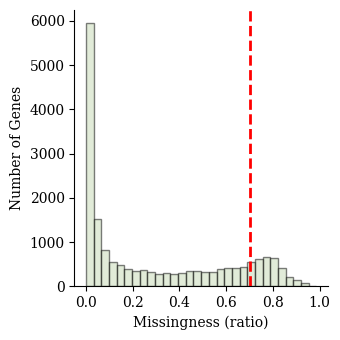

In [ ]:
# Calculate missingness for each gene
missingness = (bulk_adata.X == 0).mean(axis=0)
missingness = np.array(missingness).flatten()

# Plot the distribution
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.hist(missingness, bins=30, color=colors_cell_type[0], edgecolor='black', alpha=0.5)
ax.axvline(x=0.7, color='red', linestyle='--', linewidth=2)  # Add a vertical line at 0.7
# ax.set_title('Distribution of Gene Missingness')
ax.set_xlabel('Missingness (ratio)')
ax.set_ylabel('Number of Genes')
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)

plt.tight_layout()

plt.show()

In [ ]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.2971925668826342


In [ ]:
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']
bulk_adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]), columns=bulk_adata.var.index)
sum_count = bulk_adata.X.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(bulk_adata_df)

bulk_adata_df.head()

index                                                        A1BG  A1BG-AS1  \
sm_name               cell_type     plate_name row donor_id                   
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    1.0       5.0   
                      Myeloid cells 010        A   Donor 1    1.0      11.0   
                      NK cells      010        A   Donor 1    1.0       3.0   
                      T cells       010        A   Donor 1    5.0      12.0   
MK-5108               B cells       010        A   Donor 1    3.0       9.0   

index                                                         A2M  A2M-AS1  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    0.0      0.0   
                      Myeloid cells 010        A   Donor 1   98.0      2.0   
                      NK cells      010        A   Donor 1    3.0     16.0   
                      T cells       010        A   Donor 1    4.0      9.0   
MK-5108               B cells       010        A   Donor 1    0.0      0.0   

index                                                        A2MP1  A4GALT  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1     0.0     2.0   
                      Myeloid cells 010        A   Donor 1     0.0     0.0   
                      NK cells      010        A   Donor 1     1.0     0.0   
                      T cells       010        A   Donor 1     1.0     0.0   
MK-5108               B cells       010        A   Donor 1     0.0     4.0   

index                                                        AAAS  AACS  \
sm_name               cell_type     plate_name row donor_id               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    9.0   6.0   
                      Myeloid cells 010        A   Donor 1   19.0   8.0   
                      NK cells      010        A   Donor 1    7.0   1.0   
                      T cells       010        A   Donor 1    9.0   4.0   
MK-5108               B cells       010        A   Donor 1    5.0   3.0   

index                                                        AAGAB   AAK1  \
sm_name               cell_type     plate_name row donor_id                 
TIE2 Kinase Inhibitor B cells       010        A   Donor 1     8.0    1.0   
                      Myeloid cells 010        A   Donor 1    43.0  119.0   
                      NK cells      010        A   Donor 1     5.0   51.0   
                      T cells       010        A   Donor 1    30.0  261.0   
MK-5108               B cells       010        A   Donor 1    11.0    5.0   

index                                                        ...  ZUP1  ZW10  \
sm_name               cell_type     plate_name row donor_id  ...               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   ...  12.0   5.0   
                      Myeloid cells 010        A   Donor 1   ...  24.0  17.0   
                      NK cells      010        A   Donor 1   ...   5.0   3.0   
                      T cells       010        A   Donor 1   ...  19.0   7.0   
MK-5108               B cells       010        A   Donor 1   ...   9.0   1.0   

index                                                        ZWILCH  ZWINT  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1      5.0    0.0   
                      Myeloid cells 010        A   Donor 1     24.0    8.0   
                      NK cells      010        A   Donor 1      3.0    0.0   
                      T cells       010        A   Donor 1      5.0    3.0   
MK-5108               B cells       010        A   Donor 1      0.0    0.0   

index                                                        ZXDA  ZXDB  ZXDC  \
sm_name               cell_type     plate_name row donor_id                     
TIE2 Kinase Inhi

## Initial clustering based on cell count and sum count

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

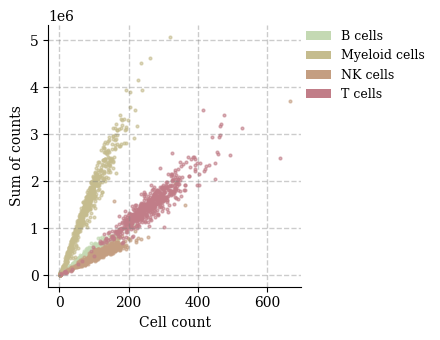

In [ ]:
xs = cell_count.values
ys = sum_count

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey=False)

plot_scatter_single(bulk_adata.obs['cell_type'], ax, xs, ys, x_label='Cell count', y_label='Sum of counts', log_x=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Cell count distribution: compound based  

In [ ]:
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
outliers_misbalance_donor_2 = ['Vorinostat']
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A']
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
outlier_compounds = outliers_toxic + outliers_two_celltype + outliers_misbalance_all + outliers_misbalance_donor_2 + outliers_misbalance_donor_3

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

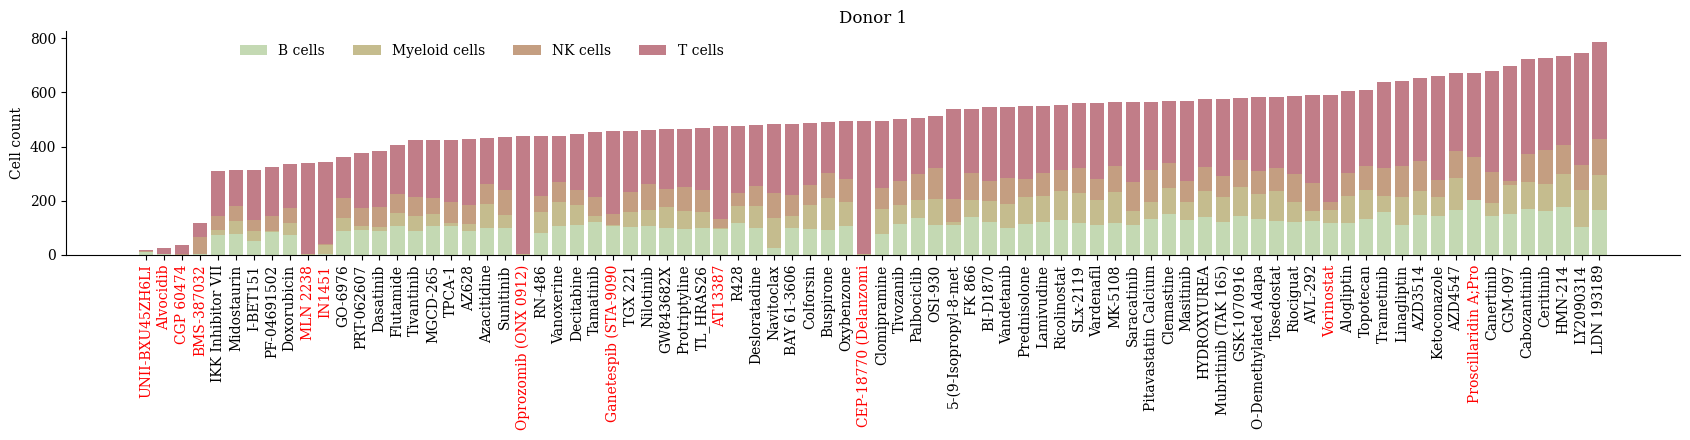

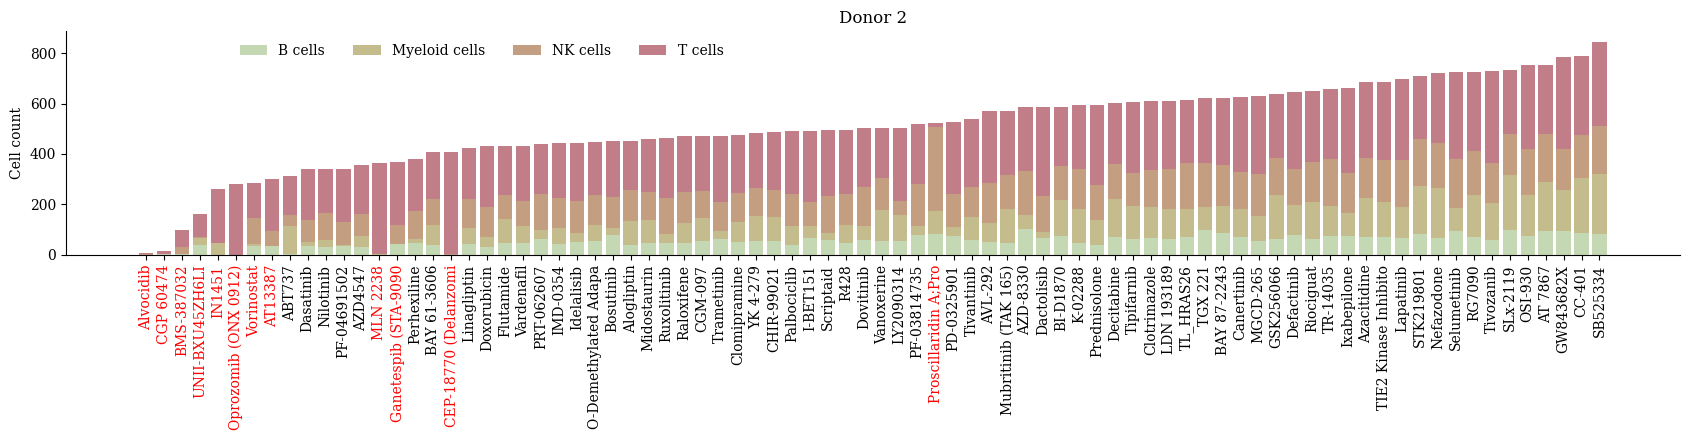

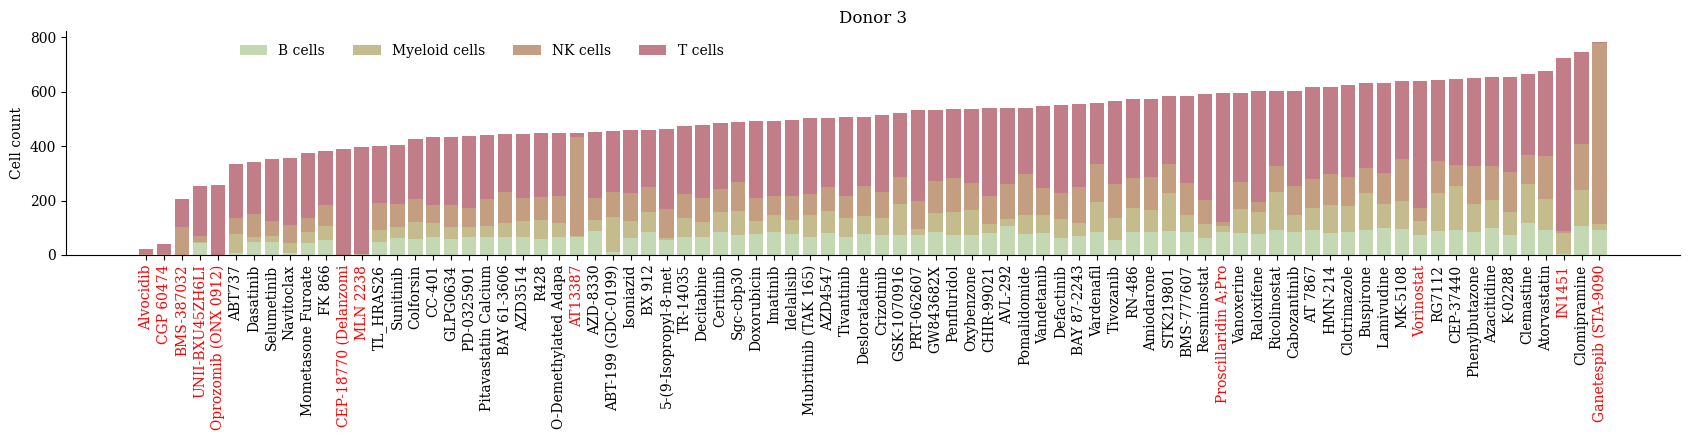

In [ ]:
bulk_adata_non_controls = bulk_adata[~bulk_adata.obs.sm_name.isin(controls3), :]
donor_ids = bulk_adata.obs.donor_id.unique()
outliers_list = []
for i_donor, donor_id in enumerate(donor_ids):
    # subset and format data
    df_subset = bulk_adata_non_controls.obs[bulk_adata_non_controls.obs.donor_id==donor_id][['sm_name', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)

    # outlier 
    outliers_if = isolation_forest(df_subset, group=['sm_name'])    
    outliers_list.append(outliers_if)
    
    # save the order
    # if i_donor==0:
    
    cell_count_m['sum'] = cell_count_m.sum(axis=1)
    cell_count_m = cell_count_m.sort_values('sum')
    cell_count_m = cell_count_m.drop(columns='sum')
    saved_order = cell_count_m.index
            
    # else:
    #     cell_count_m = cell_count_m.reindex(saved_order)

    colors = []
    masks = []
    for label in cell_count_m.index.values:
        if label in outlier_compounds:
            colors.append('red')
            mask = True
        else:
            colors.append('black')
            np.random.seed(32)
            mask = np.nan
        masks.append(mask)
    masks = np.asarray(masks)
    nan_mask = np.isnan(masks)
    random_bool = np.random.choice([True, False],size=nan_mask.sum())
    masks[nan_mask] = random_bool
    
    if True: # show only some of non outlier compounds
        cell_count_m['mask'] = masks
        cell_count_m['color'] = colors
        cell_count_m = cell_count_m[cell_count_m['mask']==True]
        colors = cell_count_m['color'].values
        cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
    # save the order
    
    xticklabels = cell_count_m.index.values
    xticklabels = [item[0:20] for item in xticklabels]
    fig, ax = plot_stacked_bar_chart(cell_count_m, title=donor_id, xticklabels=xticklabels, colors=colors, figsize=(17, 4.5))
    ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
    ax.set_ylabel('Cell count')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    plt.tight_layout()
    fig.savefig(f'{work_dir}/preprocess/figs/outliers_{donor_id}.png', dpi=150, transparent=True)

all_outliers = np.unique(np.concatenate(outliers_list))
common_outliers = list(set(outliers_list[0]).intersection(outliers_list[1], outliers_list[2]))


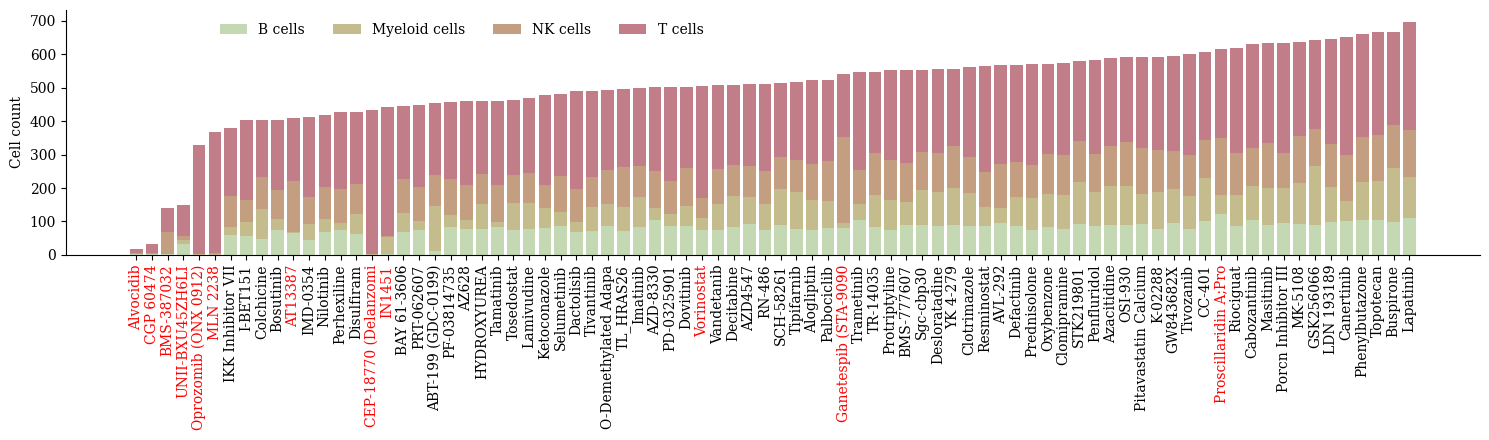

In [ ]:
# average across 
df_subset = bulk_adata_non_controls.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].mean()).to_frame().reset_index()
cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values=0)
cell_count_m = cell_count_m.fillna(0)

# save the order
cell_count_m['sum'] = cell_count_m.sum(axis=1)
cell_count_m = cell_count_m.sort_values('sum')
cell_count_m = cell_count_m.drop(columns='sum')
saved_order = cell_count_m.index

colors = []
masks = []
for label in cell_count_m.index.values:
    if label in outlier_compounds:
        colors.append('red')
        mask = True
    else:
        colors.append('black')
        np.random.seed(32)
        mask = np.nan
    masks.append(mask)
masks = np.asarray(masks)
nan_mask = np.isnan(masks)
random_bool = np.random.choice([True, False],size=nan_mask.sum())
masks[nan_mask] = random_bool

if True: # show only some of non outlier compounds
    cell_count_m['mask'] = masks
    cell_count_m['color'] = colors
    cell_count_m = cell_count_m[cell_count_m['mask']==True]
    colors = cell_count_m['color'].values
    cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
# save the order

xticklabels = cell_count_m.index.values
xticklabels = [item[0:20] for item in xticklabels]
fig, ax = plot_stacked_bar_chart(cell_count_m, title='', xticklabels=xticklabels, colors=colors, figsize=(15, 4.5))
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
ax.set_ylabel('Cell count')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/outliers_mean.png', dpi=150, transparent=True)

In [ ]:
# samples with less than 10 cells
bulk_adata_filtered = bulk_adata.copy()
# toxic ones
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_toxic),:]
# remove those with less than 10 cells left 
mask_low_cell_count = bulk_adata_filtered.obs.cell_count < 10
print(mask_low_cell_count.shape)
bulk_adata_filtered = bulk_adata_filtered[~mask_low_cell_count]
# remove those that have less than 2 cells types left per donor
to_go_compounds = []
for donor_id in bulk_adata_filtered.obs.donor_id.unique():
    adata_donor = bulk_adata_filtered[bulk_adata_filtered.obs.donor_id.eq(donor_id)]
    cell_type_n = adata_donor.obs.groupby('sm_name').size()
    to_go_compounds.append(cell_type_n[cell_type_n<=2].index.astype(str))
to_go_compounds = np.unique(np.concatenate(to_go_compounds))
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
assert np.all(to_go_compounds==outliers_two_celltype)
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(to_go_compounds),:]

# remove big class misbalance in all donors 
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A'] 
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_all),:]
# remove big class misbalance in 1 donor
outliers_misbalance_donor_2 = ['Vorinostat']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_2) & (bulk_adata_filtered.obs.donor_id=='Donor 2')),:]
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_3) & (bulk_adata_filtered.obs.donor_id=='Donor 3')),:]
 


bulk_adata_filtered

(2241,)


View of AnnData object with n_obs × n_vars = 2170 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

2


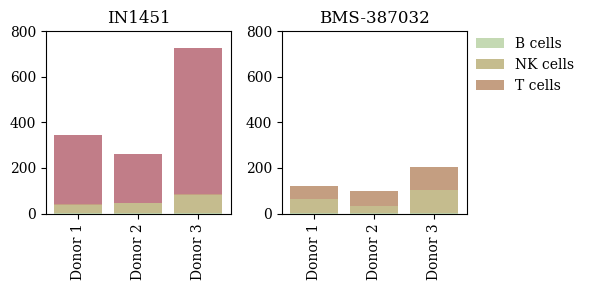

In [ ]:
# group_to_plot = np.setdiff1d(all_outliers, common_outliers)
# group_to_plot = np.setdiff1d(common_outliers, included_outliers)
group_to_plot = ['IN1451', 'BMS-387032']
n_cols = min([5, len(group_to_plot)])
n_rows = int(np.ceil(len(group_to_plot)/n_cols))
print(n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

ax_list = []
for i_compound, compound in enumerate(group_to_plot):
    i = i_compound // n_cols
    j = i_compound % n_cols
    if n_rows==1:
        ax = axes[j]
    else:
        ax = axes[i][j]
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)
    
    ax.set_ylim([0, 800])
    plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
    ax_list.append(ax)
ax_list[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()

## Missing counts

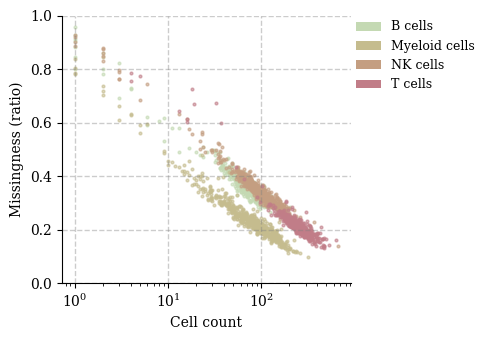

In [ ]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
bulk_adata_df = pd.DataFrame(bulk_adata.X)

xs = bulk_adata.obs.cell_count
ys = missingness


fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

plot_scatter_single(bulk_adata.obs['cell_type'], ax, xs, ys, x_label='Cell count', y_label='Missingness (ratio)')
ax.set_ylim([0, 1])
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)


## Low gene coverage 

In [ ]:
mask_to_go_genes = ((bulk_adata_filtered.X == 0).sum(axis=0)/bulk_adata_filtered.shape[0])>0.7
mask_to_go_genes.sum()

3033

In [ ]:
bulk_adata_filtered = bulk_adata_filtered[:,~mask_to_go_genes] 
bulk_adata_filtered

View of AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

In [ ]:
bulk_adata_filtered.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

In [ ]:
bulk_adata_filtered.obs.sm_name.unique().shape

(138,)

## Highly variable genes

In [ ]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [ ]:
n_hvgs = 3000

In [ ]:
%%R  -i work_dir # run this from terminal 
library(scry)
library(zellkonverter)
library(SingleCellExperiment)

work_dir = './output'
adata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = scry::devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    

RInterpreterError: Failed to parse and evaluate line '# run this from terminallibrary(scry)\nlibrary(zellkonverter)\nlibrary(SingleCellExperiment)\n\nwork_dir = \'./output\'\nadata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts\nsce = scry::devianceFeatureSelection(adata, assay="X")\nwriteH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))\n'.
R error message: "Error in py_call_impl(callable, call_args$unnamed, call_args$named) : \n  FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_f.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)\nRun `reticulate::py_last_error()` for details."
R stdout:
Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomeInfoDb
Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attaching package: ‘Biobase’

The following object is masked from ‘package:MatrixGenerics’:

    rowMedians

The following objects are masked from ‘package:matrixStats’:

    anyMissing, rowMedians

Error in py_call_impl(callable, call_args$unnamed, call_args$named) : 
  FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_f.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Run `reticulate::py_last_error()` for details.
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: Python '/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/bin/python' was requested but '/root/anaconda3/envs/py10/bin/python' was loaded instead (see reticulate::py_config() for more information)

In [ ]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

In [ ]:
# hvg vs sum 
genes = hvgs_sce
adata_f = bulk_adata
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = adata_f.var
var['sum'] = adata_f.X.sum(axis=0)
var['std'] = adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


ax.set_ylabel('Std across samples')
ax.set_xlabel('Sum across samples')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]
non_hkgs.shape

(11702,)

In [ ]:
hvgs = hvgs_sce
genesets_dict = {'HKGs':housekeeping_genes, 'Rest': non_hkgs}
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {} # top percentile score versus randomly selected genes with the same dimension
n_random = 1000
for name, geneset in genesets_dict.items():
    shared_genes = np.intersect1d(geneset, all_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(all_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
print(f'{hvgs_intersection_ratio_dict=} \n {top_p_dict=}')

hvgs_intersection_ratio_dict={'HKGs': 0.18445772843723313, 'Rest': 0.200991283541275} 
 top_p_dict={'HKGs': 0.705, 'Rest': 0.007}


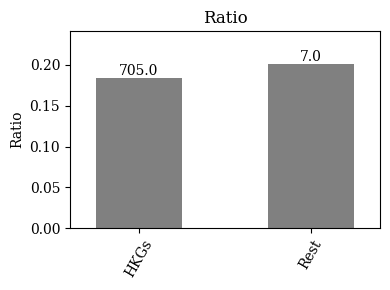

In [ ]:
hvgs = hvgs_sce

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color='grey')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(ax,  hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

# Normalize

In [ ]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

In [ ]:
bulk_adata.layers['counts'] = bulk_adata.X.copy()

### Scanpy shifted logarithm

In [ ]:
sc.pp.normalize_total(bulk_adata)
sc.pp.log1p(bulk_adata)
bulk_adata.layers['X_norm_SL'] = bulk_adata.X.copy()

### Scanpy pearson residuals
The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. 

In [ ]:
bulk_adata.X = bulk_adata.layers['counts'] 
sc.experimental.pp.normalize_pearson_residuals(bulk_adata)
bulk_adata.layers['X_norm_pearson'] = bulk_adata.X.copy()

## EDA on normalized data

In [ ]:
print('sparsity pearson:', (bulk_adata.layers[f'X_norm_pearson'].flatten()==0).sum()/bulk_adata.layers[f'X_norm_pearson'].flatten().size)
print('sparsity SLA:', (bulk_adata.layers[f'X_norm_SL'].flatten()==0).sum()/bulk_adata.layers[f'X_norm_SL'].flatten().size)

sparsity pearson: 0.0
sparsity SLA: 0.18342316202025954


## Normality

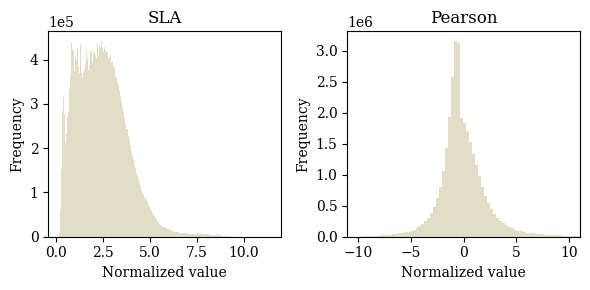

In [ ]:
import matplotlib.pyplot as plt

color = colors_cell_type[1]
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
def plot_norm(bulk_adata, norm_tag, ax):
    bulk_adata.X = bulk_adata.layers[f'X_norm_{norm_tag}'].copy()
    data = bulk_adata.X.flatten()
    data = data[data!=0]
    ax.hist(data, bins=200, color=color, alpha=.5)
    ax.set_xlabel('Normalized value')
    ax.set_ylabel('Frequency')
    if norm_tag == 'pearson':
        ax.set_xlim([-11,11])
        title = 'Pearson'
    elif norm_tag == 'SL':
        title = 'SLA'
    ax.ticklabel_format(axis='y', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
    ax.set_title(title)
    plt.tight_layout()
plot_norm(bulk_adata, norm_tag='SL', ax=axes[0])
plot_norm(bulk_adata, norm_tag='pearson', ax=axes[1])
fig.savefig(f'{work_dir}/preprocess/figs/norm_values_hist_{norm_tag}.png', dpi=100)



## Std

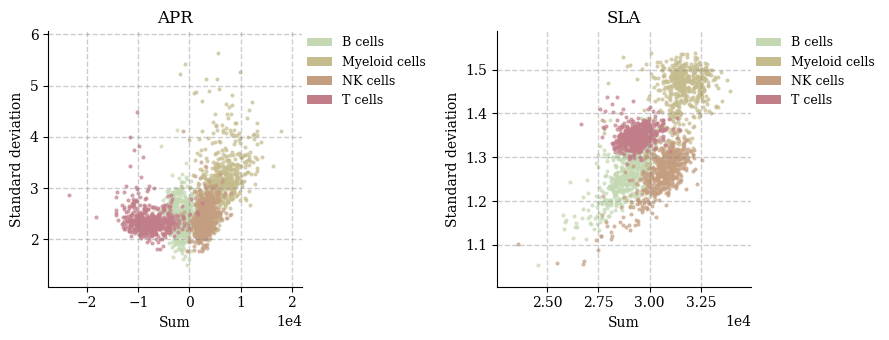

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=False)
def plot_sum_std(norm_tag, ax, title):
    
    bulk_adata.X = bulk_adata.layers[f'X_norm_{norm_tag}'].copy()
    xs = np.sum(bulk_adata.X, axis=1) # sum across genes

    std = []
    for row in bulk_adata.X:
        std.append(np.std(row[row!=0]))
    ys = np.asarray(std)

    plot_scatter_single(bulk_adata.obs['cell_type'].values, ax, xs, ys, x_label='Sum', y_label='Standard deviation', log_x=False)
    ax.set_title(title)
    for ax in axes:
        ax.margins(0.1)
        ax.ticklabel_format(axis='x', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
    
    

plot_sum_std(norm_tag='pearson', ax=axes[0], title='APR')
plot_sum_std(norm_tag='SL', ax=axes[1], title='SLA')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/std_sum_nomalized.png', dpi=100, transparent=True)


## Clusters

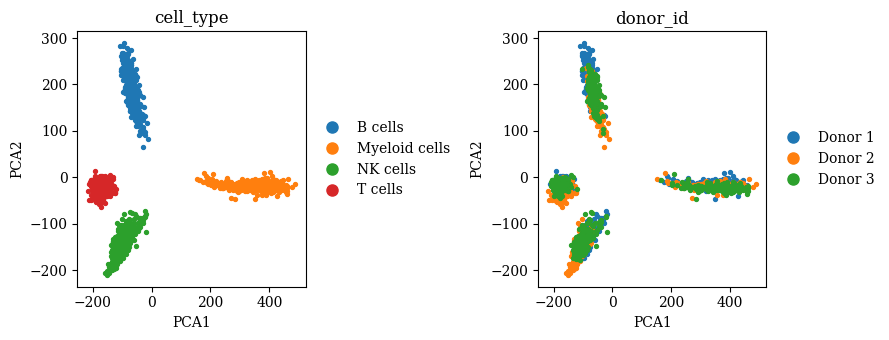

In [ ]:
def cluster_plot(adata, norm_tag, cluster='pca', var_names=['Cell type', 'donor_id']):
    bulk_adata.X = adata.layers[f'X_norm_{norm_tag}'].copy()
    fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
    # cluser 
    with warnings.catch_warnings():
        sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
        sc.tl.umap(adata)

    latent = adata.obsm[f'X_{cluster}']
    legend_handles = []  
    for i_ax, var in enumerate(var_names): 
        ax = axes[i_ax]
        var_unique = sorted(adata.obs[var].unique())  
        var_unique_sorted = sorted(var_unique)  
        for sub_var in var_unique_sorted:
            mask = adata.obs[var] == sub_var
            sub_data = latent[mask]
            scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=8)
            legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

        ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

        if cluster == 'pca':
            ax.set_xlabel('PCA1')
            ax.set_ylabel('PCA2')
        else:
            ax.set_xlabel('UMAP1')
            ax.set_ylabel('UMAP2')
        ax.set_title(var)

    plt.tight_layout()
    plt.show()

    fig.savefig(f'{work_dir}/preprocess/figs/normalized_cluster_{norm_tag}_{cluster}.png', dpi=150, transparent=True)

cluster_plot(bulk_adata, norm_tag='pearson', cluster='pca', var_names=['cell_type', 'donor_id'])

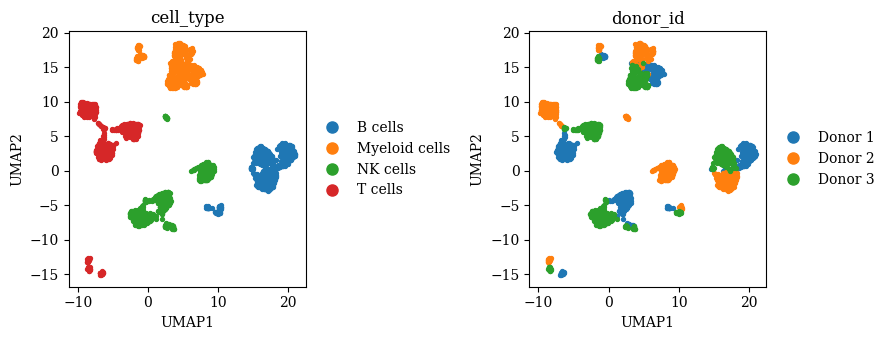

In [ ]:
cluster_plot(bulk_adata, norm_tag='pearson', cluster='umap', var_names=['cell_type', 'donor_id'])

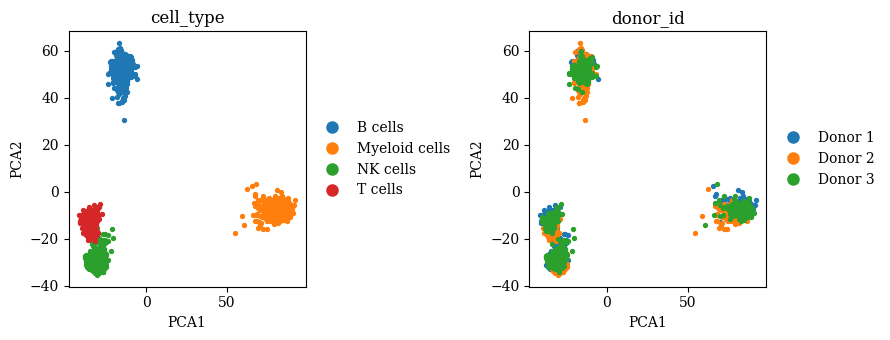

In [ ]:
cluster_plot(bulk_adata, norm_tag='SL', cluster='pca', var_names=['cell_type', 'donor_id'])

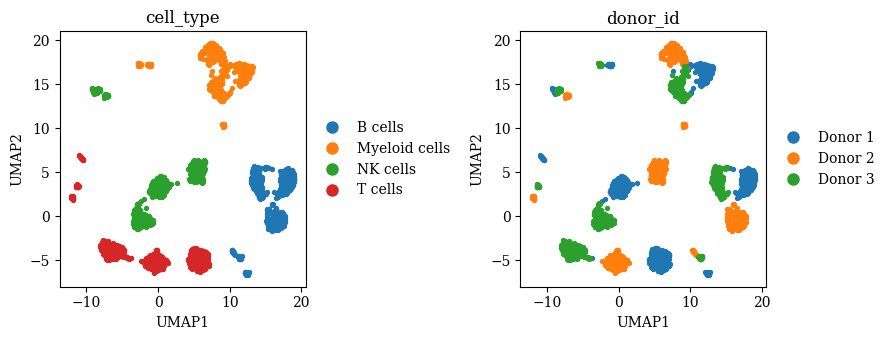

In [ ]:
cluster_plot(bulk_adata, norm_tag='SL', cluster='umap', var_names=['cell_type', 'donor_id'])

In [ ]:
bulk_adata.obs = bulk_adata.obs[['cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type']]
bulk_adata.var = bulk_adata.var[[]]
del bulk_adata.uns 
del bulk_adata.obsm
del bulk_adata.varm
del bulk_adata.obsp
bulk_adata.X = bulk_adata.layers['counts'].copy()
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
